# LDA

## Contents
- 1. 데이터 전처리
    - 1-1. 알파벳만 남기기
    - 1-2. 스톱워드 제거
    - 1-3. 단어 원형화 
    - 1-4. 딕셔너리, 코퍼스 만들기
    
- 2. LDA
    - 2-1. Coherence score
    - 2-2. 토픽모델링 

## 1. 데이터 전처리

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
pd.set_option('display.max_rows',100)
import re

In [2]:
data = pd.read_csv('/Users/jin/Documents/pythonstudy/NLP/frip_data/frip_data_translate_part11_full_ver2.csv', index_col=0)

In [3]:
data = data[data['제목'] == '[2030] 국내최초 1박2일 불멍스키 혼펜 _따로 또 같이']
data.reset_index(drop=True, inplace=True)

## 1-1. 알파벳만 남기기

In [4]:
# 구두점 제거 
def clean_text(d):
    pattern = r'[^a-zA-Z\s]'       # 정규표현식, 알파벳으로만 된 것 
    text = re.sub(pattern, '', d)  # 패턴에 해당하는 것은 삭제 , 패턴에 해당하는 것은 '' 로 바꾼다, 데이터는 d다 
    return text

data['clean_word'] = data['번역'].apply(clean_text)

# 데이터 체크
print('1. Raw :',data['내용'][2])
print('2. Korean Preprocess :',data['s_review'][2])
print('3. Translate :',data['번역'][2])
# print('4. After stopword :',bake['Drop_stopword'][2])
print('5. After clean :',data['clean_word'][2])

1. Raw : 추운 날씨였지만 1박2일 동안 재미 있었어요. 다른 계절에도  방문해보고 싶네요. 그리고 펜션냥이와  강아지가 또 보고 십네요.  다만 조를 나누다보니 제한된 인원만 친해지게 되서 아쉽게 느낍니다.
2. Korean Preprocess : 추운 날씨였지만 1박2일 동안 재미 있었어요 다른 계절에도 방문해보고 싶네요 그리고 펜션 냥이와 강아지가 또 보고 십네요 다만 조를 나누다 보니 제한된 인원만 친해지게 되서 아쉽게 느낍니다
3. Translate : It was cold weather, but it was fun for one night and two days. I want to visit other seasons. And I see pensions and dogs again. However, when I share the group, I feel sorry that only limited people get close
5. After clean : It was cold weather but it was fun for one night and two days I want to visit other seasons And I see pensions and dogs again However when I share the group I feel sorry that only limited people get close


## 1-2. 스톱워드 처리

In [6]:
# 스톱워드 처리
import re
from nltk.corpus import stopwords

# stopword
stop_word = stopwords.words('english')
add_stopword = ["I've", "really","away",'able','first','there',
                'even',"that's","time",'well','thank','ill',
                "can't","time.","time,","week.",'week',"next",
                'host', "something","go","I'll",'ill',"You're",'youre',
               'class']
stop_word.extend(add_stopword)

def clean_stopword(d):
    #stop_words = stopwords.words('english')       # stopword 
    stop_words = stop_word
    return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) >3 ]) 
# stopword 제외, 3개 이하 제외, 소문자 

In [7]:
data['Drop_stopword'] = data['clean_word'].apply(clean_stopword)

In [8]:
# 데이터 체크
print('1. Raw :',data['내용'][2])
print('2. Korean Preprocess :',data['s_review'][2])
print('3. Translate :',data['번역'][2])
print('4. After stopword :',data['Drop_stopword'][2])

1. Raw : 추운 날씨였지만 1박2일 동안 재미 있었어요. 다른 계절에도  방문해보고 싶네요. 그리고 펜션냥이와  강아지가 또 보고 십네요.  다만 조를 나누다보니 제한된 인원만 친해지게 되서 아쉽게 느낍니다.
2. Korean Preprocess : 추운 날씨였지만 1박2일 동안 재미 있었어요 다른 계절에도 방문해보고 싶네요 그리고 펜션 냥이와 강아지가 또 보고 십네요 다만 조를 나누다 보니 제한된 인원만 친해지게 되서 아쉽게 느낍니다
3. Translate : It was cold weather, but it was fun for one night and two days. I want to visit other seasons. And I see pensions and dogs again. However, when I share the group, I feel sorry that only limited people get close
4. After stopword : cold weather night days want visit seasons pensions dogs however share group feel sorry limited people close


## 1-3. 단어 원형화

In [9]:
# lemmatize 함수 
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
def penn_to_wn(tag):
    if tag.startswith('J'):  # 문자열.statswith('문자1') : 문자열 앞이 문자1로 시작하나?
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    
def token_lemma(raw_sentence):
    lemmatizer = WordNetLemmatizer()
    lemmas=[]

    tagged_sentence = pos_tag(word_tokenize(raw_sentence))
    for word, tag in tagged_sentence:
            
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
            continue  # 명사, 형용사, 부사, 동사가 아니면 아무것도 안한다.
            
        # 그렇지 않으면, 원형화 한다. (명사, 형용사, 부사면 원형화 한다.)
        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        lemmas.append(lemma)
    return lemmas

tokenized_data = data['Drop_stopword'].apply(token_lemma)

In [10]:
# 데이터 체크

def check_data(data, num):
    print('1. Raw :',data['내용'][num])
    print('2. Korean Preprocess :',data['s_review'][num])
    print('3. Translate :',data['번역'][num])
    print('4. After stopword :',data['Drop_stopword'][num])
    print('5. After clean :',data['clean_word'][num])
    print('6. tokens :', tokenized_data[num])

In [11]:
check_data(data,3)

1. Raw : 너무 재밌고 좋았습니다 위스키도 자세히 설명해주시고 바베큐랑 불멍까지 완벽했어요ㅠㅠ감사합니다 들숨날숨에 번창하시길 바랍니다!! 날풀리면 또갈께요!!
2. Korean Preprocess : 너무 재밌고 좋았습니다 위스키도 자세히 설명해주시고 바베큐랑 불멍까지 완벽했어요 감사합니다 들 숨날 숨에 번창하시길 바랍니다 날 풀리면 또 갈께 요
3. Translate : It was so fun and good. You can explain the whiskey in detail, and the barbecue and the bum are perfect. Thank you.
4. After stopword : good explain whiskey detail barbecue perfect thank
5. After clean : It was so fun and good You can explain the whiskey in detail and the barbecue and the bum are perfect Thank you
6. tokens : ['good', 'explain', 'whiskey', 'detail', 'barbecue', 'perfect', 'thank']


## 1-4. 딕셔너리, 코퍼스 만들기

In [12]:
# 빈도 구하기
# 딕셔너리 , 코퍼스 만들기 
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]
print(corpus[1]) 

[(2, 1), (6, 2), (7, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 3), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 3), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3)]


## 2. LDA

## 2-1. Coherence Score

In [13]:
# 토픽 수 결정하기
# 10개를 넘지 않는다고 가정 
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

min_topics, max_topics = 1, 11
coherence_scores = []
perplexs = []

for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus, num_topics = num_topics, id2word=dictionary,
                    random_state=7)
    coherence = CoherenceModel(model = model, 
                              texts = tokenized_data, # 여기도 바꿔줘야 함
                              dictionary=dictionary)
    
    coherence_scores.append(coherence.get_coherence())
    perplexs.append(model.log_perplexity(corpus))

print(coherence_scores)

[0.43194139608432264, 0.43215173986781596, 0.4799334169067258, 0.47294188640148416, 0.4633703878603722, 0.44035819417658995, 0.4431533093779182, 0.44237123418788793, 0.44690544890652156, 0.4370473092464079]


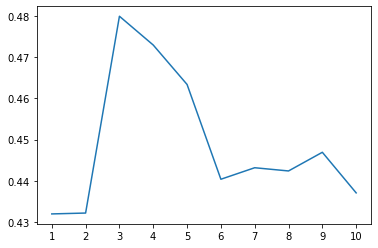

In [14]:
x = np.arange(1,11,1)
y = coherence_scores 
g = sns.lineplot(x,y)
g.set_xticks(x)
plt.show()

## 2-2. 토픽모델링

In [17]:
# 토픽결정
NUM_TOPICS = 9 # 20개의 토픽, k=20
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary,
                   random_state=7)
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.031*"good" + 0.016*"rest" + 0.012*"happy" + 0.011*"alone" + 0.011*"take" + 0.010*"heal" + 0.009*"come" + 0.009*"think" + 0.009*"like" + 0.009*"go"')
(1, '0.013*"good" + 0.013*"go" + 0.012*"night" + 0.012*"experience" + 0.012*"make" + 0.012*"whiskey" + 0.011*"people" + 0.011*"manager" + 0.010*"cute" + 0.009*"much"')
(2, '0.030*"good" + 0.016*"want" + 0.012*"pension" + 0.011*"happy" + 0.010*"whiskey" + 0.008*"life" + 0.008*"talk" + 0.008*"night" + 0.007*"people" + 0.007*"like"')
(3, '0.021*"good" + 0.019*"people" + 0.019*"want" + 0.013*"happy" + 0.012*"take" + 0.011*"talk" + 0.011*"think" + 0.011*"alone" + 0.011*"come" + 0.010*"place"')
(4, '0.059*"good" + 0.023*"people" + 0.016*"think" + 0.014*"happy" + 0.012*"come" + 0.011*"room" + 0.011*"alone" + 0.009*"meat" + 0.009*"want" + 0.008*"delicious"')
(5, '0.027*"alone" + 0.023*"good" + 0.015*"go" + 0.014*"like" + 0.014*"come" + 0.012*"heal" + 0.012*"enjoy" + 0.012*"night" + 0.011*"people" + 0.011*"honpen"')
(6, '0.026*"good" + 0.025

In [18]:
# 토픽 뽑아내기 
topics = []
for i in range(len(tokenized_data)):
    sortresult = sorted(ldamodel[corpus][i], key = lambda x: x[1], reverse=True)
    topic = sortresult[0][0]
    topics.append(topic)

In [19]:
# 토픽 컬럼 만들기 
data['Topic'] = topics

In [20]:
# 체크함수 
def checkprint(data, num):
    print('1. Raw :',data['내용'][num])
    print('2. Korean Preprocess :',data['s_review'][num])
    print('3. Translate :',data['번역'][num])
    print('4. After stopword :',data['Drop_stopword'][num])
    print('5. After clean :',data['clean_word'][num])
    print('6. tokens :', tokenized_data[num])
    print('7. Topic :', data['Topic'][num])

In [59]:
checkprint(data, 21)

1. Raw : 작년 이맘때쯤부터 계속 고민하다가 1년만에 결정!

생각 정리 겸 혼자만의 시간이 필요한 건 맞는데, 자발적 혼자를 굳이 선택하고 싶지 않고 😔
혼자인 듯 혼자 아닌 게 마음에 들어서 참여하게 된 거 같아요!

그날의 분위기가 다 다르겠지만, 대부분이 쉬고 싶은 마음에 참여하셔서 적정한 텐션으로 팀원끼리 이야기하고 불멍, 물멍할 수 있었던 거 같아요.

위스키바에서 호스트님이랑 다른 분들하고 이야기 나눈 것도 좋았고, 불멍 때 🍖 , 힙플라스크에 🥃, 마시멜로우, 쫀드기, 🍠, 블루투스 🔊, 그리고 개냥이들…

세심한  준비 덕에 만족도 높아지고,
혼자 쓰는 복층 펜션이 잘 땐 너무 무서웠는데… 
또 편하긴 하고ㅎㅎㅎ

무릎에 올라오기까지 하는 개냥이들 쓰담하며 아무 생각없이 있을 수 있어서 너무 좋았습니다!

다른 계절에 또 뵐게요!
2. Korean Preprocess : 작년 이맘 때쯤부터 계속 고민하다가 1년 만에 결정 생각 정리 겸 혼자만의 시간이 필요한 건 맞는데 자발적 혼자를 굳이 선택하고 싶지 않고 혼자인 듯 혼자 아닌 게 마음에 들어서 참여하게 된 거 같아 요 그날의 분위기가 다 다르겠지만 대부분이 쉬고 싶은 마음에 참여하셔서 적정한 텐션으로 팀원끼리 이야기하고 불멍 물멍할 수 있었던 거 같아 요   위스키바에서 호스트님이랑 다른 분들 하고 이야기 나 눈 것도 좋았고 불멍 때 힙플라스크에 마시멜로우 쫀드기 블루투스 그리고 개냥이들 세심한 준비 덕에 만족도 높아지고 혼자 쓰는 복층 펜션이 잘 땐 너무 무서웠는데 또 편하긴 하고 무릎에 올라오기까지 하는 개냥이들 쓰담하며 아무 생각 없이 있을 수 있어서 너무 좋았습 니다 다른 계절에 또 뵐게요
3. Translate : I have been thinking about this time last year, but I need to organize my decision and spend my time alone in a year. I do not want to choose myself 

- 0 : 심리적
- 1 : 개인적만족
- 2 : 심리적
- 3 : 사회적
- 4 : 사회적
- 5 : 심리적
- 6 : 사회적
- 7 : 사회적
- 8 : 사회적

In [58]:
data[data['Topic'] == 8].index

Int64Index([  5,   6,  21,  39,  40,  54,  67,  69,  71,  78,  98, 103, 110,
            127, 128, 129, 132, 138, 145, 147, 151, 152, 157, 158, 166, 192,
            194, 195, 198, 205, 207, 226, 234, 235, 239, 244, 249, 251, 253,
            259, 262, 286, 302, 315, 324, 325, 336, 343, 349, 353, 361, 363,
            365, 373, 374],
           dtype='int64')

In [61]:
data['Topic_code'] = data['Topic'].replace([0,1,2,3,4,5,6,7,8],
                                          ['심리적','개인적만족','심리적','사회적','사회적','심리적','사회적','사회적','사회적'])

In [62]:
data['Topic_code'].value_counts()

사회적      217
심리적      134
개인적만족     24
Name: Topic_code, dtype: int64

In [63]:
data.to_csv('/Users/jin/Documents/pythonstudy/NLP/frip_data_lda/lda13.csv')

## 전체 반복진행

- 활동별로 반복진행하였습니다. 